In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from sklearn.metrics import jaccard_score
from skimage.measure import label
from natsort import natsorted
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import pandas as pd
import seaborn as sns
from skimage.measure import regionprops_table
import zarr
from skimage.morphology import binary_erosion
from glob import glob

Naive IoU

In [2]:
def correct_masks_for_DeLTA(masks):
    mask_labels = np.unique(masks)[1:]
    eroded_masks = np.zeros(masks.shape, dtype=bool)
    for mask_label in mask_labels:
        eroded_masks += binary_erosion(masks == mask_label).astype(bool)
    return eroded_masks

In [4]:
data_dirs = glob("data/*")


output = []
for data_dir in tqdm(data_dirs):
    dataset_name = data_dir.split("/")[1]
    dataset_mask_dirs = natsorted(glob(f"{data_dir}/test_data/*_mask*"))
    #gt_masks = [correct_masks_for_DeLTA(np.array(Image.open(x))) for x in dataset_mask_dirs]
    gt_masks = Parallel(n_jobs=-1)(delayed(correct_masks_for_DeLTA)(np.array(Image.open(x))) for x in dataset_mask_dirs)
    for seg_dir in tqdm(glob(f"{data_dir}/DeLTA_segmented_by/*")):
        model_name = seg_dir.split("/")[-1]
        seg_mask_dirs = natsorted(glob(f"{seg_dir}/*"))
        seg_masks = [np.array(Image.open(directory))[16:-16,16:-16] for directory in seg_mask_dirs]
        IoU = Parallel(n_jobs=-1)(delayed(jaccard_score)(x, y.astype(bool), average="micro") for x, y in zip(gt_masks, seg_masks))
        output.append([dataset_name, model_name, np.mean(IoU)])
        
output_df = pd.DataFrame(output)
output_df.columns = ["Dataset", "Model", "IoU"]

heatmap_data = output_df.groupby(["Model", "Dataset"]).mean()["IoU"].reset_index().pivot(columns='Model',index='Dataset',values='IoU')
#heatmap_data = heatmap_data[ ["1_1", "3_3", "5_5", "7_7", "9_9", "1_9", "bact_fluor_omni"]]
#heatmap_data.index = pd.CategoricalIndex(heatmap_data.index, categories= ["1_1", "3_3", "5_5", "7_7", "1_9", "9_9"])
heatmap_data.sort_index(level=0, inplace=True)
sns.heatmap(heatmap_data)
plt.title("DeLTA IoU")

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_19806/1220140778.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/tmp/ipykernel_19806/1220140778.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/tmp/ipykernel_19806/1220140778.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/tmp/ipykernel_19806/1220140778.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/tmp/ipykernel_19806/1220140778.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/tmp/ipykernel_19806/1220140778.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/tmp/ipykernel_19806/1220140778.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


KeyboardInterrupt: 

In [1]:
data_dirs = glob("data/*")


output = []
for data_dir in tqdm(data_dirs):
    dataset_name = data_dir.split("/")[1]
    dataset_mask_dirs = natsorted(glob(f"{data_dir}/test_data/*_mask*"))
    gt_masks = [np.array(Image.open(x)) for x in dataset_mask_dirs]
    for seg_dir in tqdm(glob(f"{data_dir}/Omnipose_segmented_by/*")):
        model_name = seg_dir.split("/")[-1]
        seg_mask_dirs = natsorted(glob(f"{seg_dir}/*"))
        seg_masks = [np.array(Image.open(directory)) for directory in seg_mask_dirs]
        IoU = Parallel(n_jobs=-1)(delayed(jaccard_score)((x.astype(bool)), y.astype(bool), average="micro") for x, y in zip(gt_masks, seg_masks))
        output.append([dataset_name, model_name, np.mean(IoU)])
        
output_df = pd.DataFrame(output)
output_df.columns = ["Dataset", "Model", "IoU"]

heatmap_data = output_df.groupby(["Model", "Dataset"]).mean()["IoU"].reset_index().pivot(columns='Model',index='Dataset',values='IoU')
#heatmap_data = heatmap_data[ ["1_1", "3_3", "5_5", "7_7", "9_9", "1_9", "bact_fluor_omni"]]
#heatmap_data.index = pd.CategoricalIndex(heatmap_data.index, categories= ["1_1", "3_3", "5_5", "7_7", "1_9", "9_9"])
heatmap_data.sort_index(level=0, inplace=True)
sns.heatmap(heatmap_data)
plt.title("Omnipose IoU")

NameError: name 'glob' is not defined

In [3]:
def get_corresponding_label(image, ground_truth_image, label):
    image_label_pixels = image[np.where(ground_truth_image == label)]
    image_label_counts = np.bincount(image_label_pixels)
    corresponding_label = np.argmax(image_label_counts)
    return corresponding_label 

In [4]:
def get_IoUs(ground_truth_segmentation, model_segmentation, dataset_name, model_name):
    ground_truth_segmentation = label(ground_truth_segmentation)
    model_segmentation = label(model_segmentation)
    ground_truth_labels = np.unique(ground_truth_segmentation)
    model_IoUs = []
    cell_dfs = []
    cell_size = []

    ground_truth_regionprops = pd.DataFrame(regionprops_table(ground_truth_segmentation, properties =  ["label", "axis_minor_length", "axis_major_length", "area"]))
    ground_truth_regionprops["Model"] = "Ground truth"
    model_regionprops = pd.DataFrame(regionprops_table(model_segmentation, properties =  ["label", "axis_minor_length", "axis_major_length", "area"]))
    model_regionprops["Model"] = model_name
    model_regionprops["Dataset"] = dataset_name

    for ground_truth_label in (ground_truth_labels):
        if ground_truth_label:
            model_label = get_corresponding_label(model_segmentation, ground_truth_segmentation, ground_truth_label)
            single_ground_truth_cell = (ground_truth_segmentation == ground_truth_label)
            cell_size.append(np.sum(single_ground_truth_cell))

            if model_label == 0:
                model_IoU = 0
            else:
                model_IoU = jaccard_score(single_ground_truth_cell, model_segmentation == model_label, average="micro")

            model_IoUs.append(model_IoU)

            #cell_dfs.append([ground_truth_regionprops.query("label == @ground_truth_label"), model_regionprops.query("label == @model_label")])

            gt_small_df = ground_truth_regionprops.query("label == @ground_truth_label").reset_index(drop=True).drop(columns=["Model"])
            gt_small_df.columns = ["GT label", "GT length", "GT width", "GT area"]
            seg_small_df = model_regionprops.query("label == @model_label").reset_index(drop=True)
            seg_small_df.columns = ["Seg label", "Seg length", "Seg width", "Seg area", "Model", "Dataset"]
            joint_data = pd.concat([gt_small_df, seg_small_df], axis=1)
            joint_data["IoU"] = model_IoU
            cell_dfs.append(joint_data)

    master_cell_df = pd.concat(cell_dfs)
    
    return master_cell_df

In [ ]:
data_dirs = glob("data/*")
all_data = []
for data_dir in tqdm(data_dirs):
    dataset_name = data_dir.split("/")[1]
    dataset_mask_dirs = natsorted(glob(f"{data_dir}/test_data/*_mask*"))
    
    dataset_masks = [np.array(Image.open(directory)) for directory in dataset_mask_dirs]
    
    for seg_dir in tqdm(glob(f"{data_dir}/Omnipose_segmented_by/*")):
        model_name = seg_dir.split("/")[-1]
        seg_mask_dirs = natsorted(glob(f"{seg_dir}/*"))
        seg_masks = [np.array(Image.open(directory)) for directory in seg_mask_dirs]
        
        _ = Parallel(n_jobs=-1, backend="multiprocessing")(delayed(get_IoUs)(gt_seg, mod_seg, dataset_name, model_name) for gt_seg, mod_seg in tqdm(zip(dataset_masks, seg_masks), total = len(seg_masks)))
        all_data.extend(_)

Text(0.5, 1.0, 'IoU')

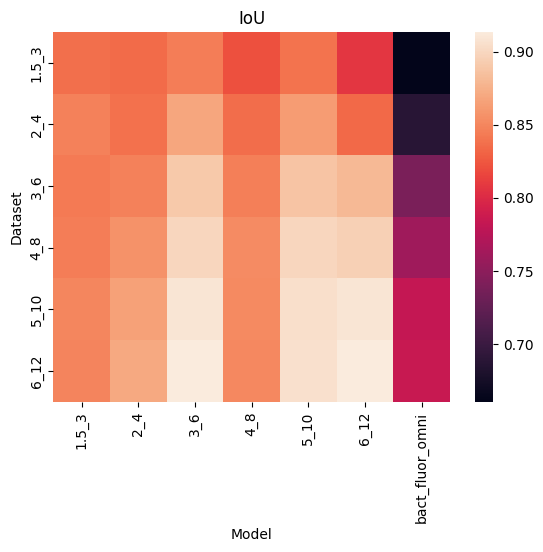

In [10]:
all_data_df = pd.concat(all_data).drop_duplicates()

#all_data_df.to_csv("all_data.csv")

all_data_df["Observed area / True area"] = all_data_df["Seg area"] / all_data_df["GT area"]


heatmap_data = all_data_df.groupby(["Model", "Dataset"]).mean()["IoU"].reset_index().pivot(columns='Model',index='Dataset',values='IoU')
#heatmap_data = heatmap_data[ ["1_1", "3_3", "5_5", "7_7", "9_9", "1_9", "bact_fluor_omni"]]
#heatmap_data.index = pd.CategoricalIndex(heatmap_data.index, categories= ["1_1", "3_3", "5_5", "7_7", "1_9", "9_9"])
heatmap_data.sort_index(level=0, inplace=True)
sns.heatmap(heatmap_data)
plt.title("IoU")

In [17]:
data_dirs = glob("data/*")
all_data_DeLTA = []
for data_dir in tqdm(data_dirs):
    dataset_name = data_dir.split("/")[1]
    dataset_mask_dirs = natsorted(glob(f"{data_dir}/test_data/*_mask*"))
    
    dataset_masks = Parallel(n_jobs=-1, backend="multiprocessing")(delayed(correct_masks_for_DeLTA)(np.array(Image.open(x))) for x in dataset_mask_dirs)
    for seg_dir in tqdm(glob(f"{data_dir}/DeLTA_segmented_by/*")):
        model_name = seg_dir.split("/")[-1]
        seg_mask_dirs = natsorted(glob(f"{seg_dir}/*"))
        seg_masks = [np.array(Image.open(directory))[16:-16,16:-16] for directory in seg_mask_dirs]
        
        _ = Parallel(n_jobs=-1, backend="multiprocessing")(delayed(get_IoUs)(gt_seg, mod_seg, dataset_name, model_name) for gt_seg, mod_seg in tqdm(zip(dataset_masks, seg_masks), total = len(seg_masks)))
        pd.concat(_).to_pickle(f"results/dataset_{dataset_name}_model_{model_name}_results.pickle")
        all_data_DeLTA.extend(_)
        

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Text(0.5, 1.0, 'IoU')

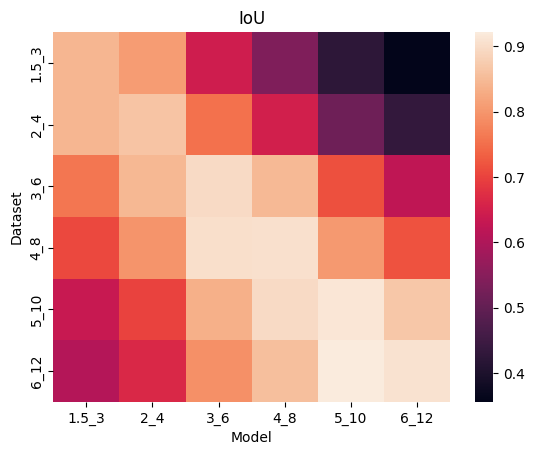

In [19]:
all_data_df = pd.concat(all_data_DeLTA).drop_duplicates()

#all_data_df.to_csv("all_data.csv")

all_data_df["Observed area / True area"] = all_data_df["Seg area"] / all_data_df["GT area"]


heatmap_data = all_data_df.groupby(["Model", "Dataset"]).mean()["IoU"].reset_index().pivot(columns='Model',index='Dataset',values='IoU')
#heatmap_data = heatmap_data[ ["1_1", "3_3", "5_5", "7_7", "9_9", "1_9", "bact_fluor_omni"]]
#heatmap_data.index = pd.CategoricalIndex(heatmap_data.index, categories= ["1_1", "3_3", "5_5", "7_7", "1_9", "9_9"])
heatmap_data.sort_index(level=0, inplace=True)
sns.heatmap(heatmap_data)
plt.title("IoU")

In [20]:
all_data_df.to_pickle("DeLTA_segmentation_results.pickle")

Text(0.5, 1.0, 'Obs / True Area')

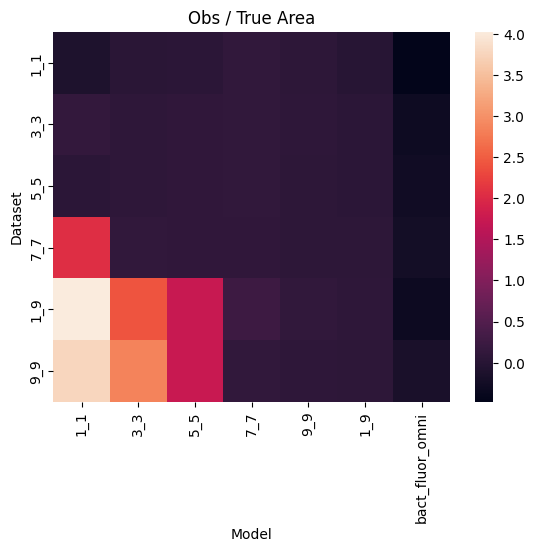

In [257]:
heatmap_data = all_data_df.groupby(["Model", "Dataset"]).mean()["Observed area / True area"].reset_index().pivot(columns='Model',index='Dataset',values='Observed area / True area')
heatmap_data = heatmap_data[ ["1_1", "3_3", "5_5", "7_7", "9_9", "1_9", "bact_fluor_omni"]]
heatmap_data.index = pd.CategoricalIndex(heatmap_data.index, categories= ["1_1", "3_3", "5_5", "7_7", "1_9", "9_9"])
heatmap_data.sort_index(level=0, inplace=True)
heatmap_data = np.log(heatmap_data)
#eatmap_data -= 1
sns.heatmap(heatmap_data),# vmax=2, cmap="PuOr")
plt.title("Obs / True Area")

In [22]:
syn_IoUs = []
pre_IoUs = []
cell_sizes = []
cell_dfs = []
for syn_IoU, pre_IoU, cell_size, cell_df in IoUs:
    syn_IoUs.extend(syn_IoU)
    pre_IoUs.extend(pre_IoU)
    cell_sizes.extend(cell_size)
    cell_dfs.append(cell_df)

NameError: name 'IoUs' is not defined

In [143]:
master_cell_df = pd.concat(cell_dfs)
master_cell_df["axis_minor_length"] *= 0.065
master_cell_df["axis_major_length"] *= 0.065
master_cell_df["area"] *= 0.065**2

In [145]:
master_cell_df.to_pickle("omnipose_size_data.pickle")

<AxesSubplot:xlabel='axis_minor_length', ylabel='Density'>

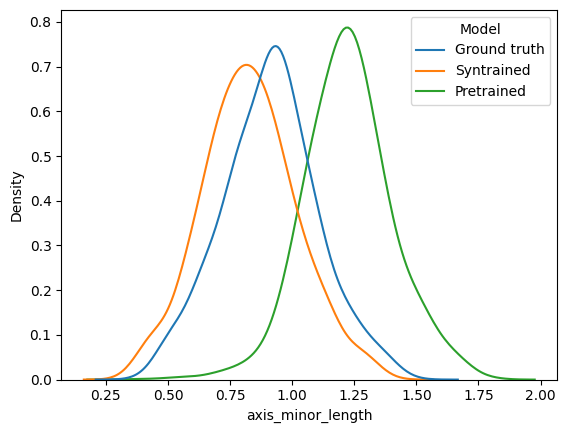

In [96]:
sns.kdeplot(data = master_cell_df, hue = "Model", x = "axis_minor_length", bw_adjust=1.7)

<AxesSubplot:xlabel='area', ylabel='Density'>

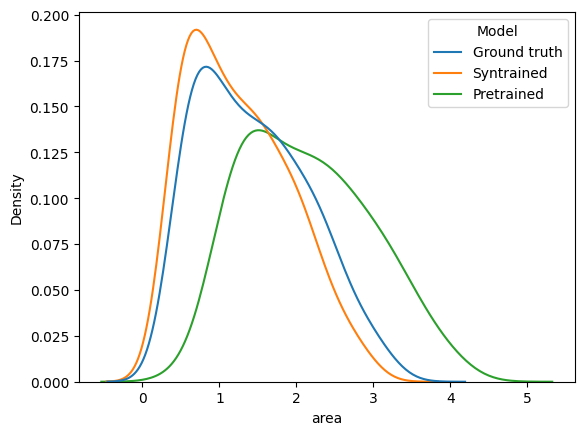

In [97]:
sns.kdeplot(data = master_cell_df, hue = "Model", x = "area", bw_adjust=1.7)

In [157]:
IoU_data = pd.DataFrame()
IoU_data["IoU"] = syn_IoUs + pre_IoUs
IoU_data["Cell size"] = cell_sizes + cell_sizes
IoU_data["Model"] = ["Syn-trained"] * len(syn_IoUs) + ["Pretrained"] * len(pre_IoUs)
bins = 7
IoU_data['Cell size (binned)'] = pd.cut(IoU_data["Cell size"], bins=bins, labels=[i for i in sorted([x.mid * (0.065**2) for x in pd.cut(IoU_data["Cell size"], bins=bins).unique()]) ]).astype(float)

In [158]:
IoU_data.to_pickle("omnipose_IoU_data.pickle")

In [159]:
IoU_data.groupby(["Cell size (binned)", "Model"]).mean()

IoU   Cell size
Cell size (binned) Model                            
0.490001           Pretrained   0.450571  131.101147
                   Syn-trained  0.711219  131.101147
0.950927           Pretrained   0.613772  221.913082
                   Syn-trained  0.774056  221.913082
1.410246           Pretrained   0.679033  334.789256
                   Syn-trained  0.811264  334.789256
1.869563           Pretrained   0.716318  442.600490
                   Syn-trained  0.833796  442.600490
2.328879           Pretrained   0.738862  547.957187
                   Syn-trained  0.847987  547.957187
2.788198           Pretrained   0.763185  656.804878
                   Syn-trained  0.864464  656.804878
3.247517           Pretrained   0.780684  750.928571
                   Syn-trained  0.872350  750.928571

<AxesSubplot:xlabel='Model', ylabel='IoU'>

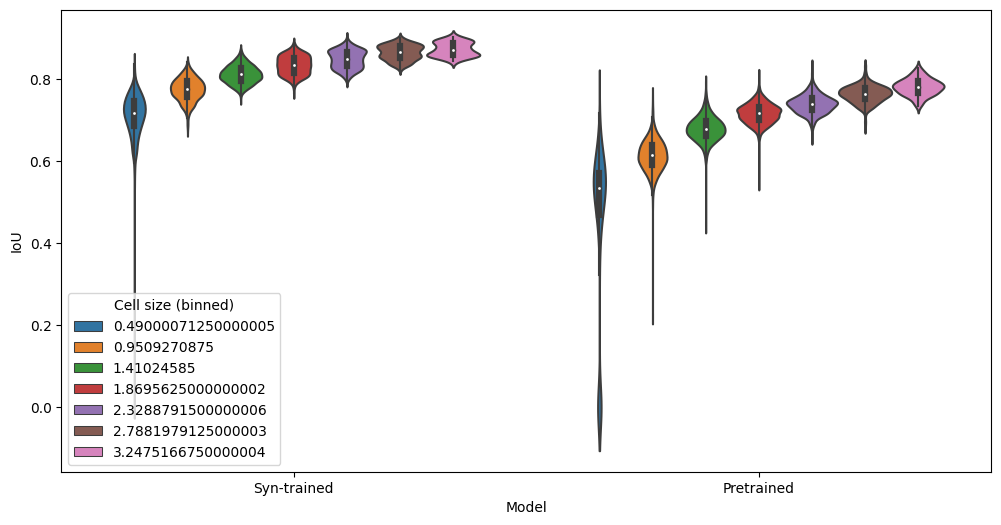

In [160]:
plt.figure(figsize=(12,6))
sns.violinplot(data = IoU_data, x = "Model", y = "IoU", hue="Cell size (binned)", split=False) # generalised IoU

<AxesSubplot:xlabel='Model', ylabel='IoU'>

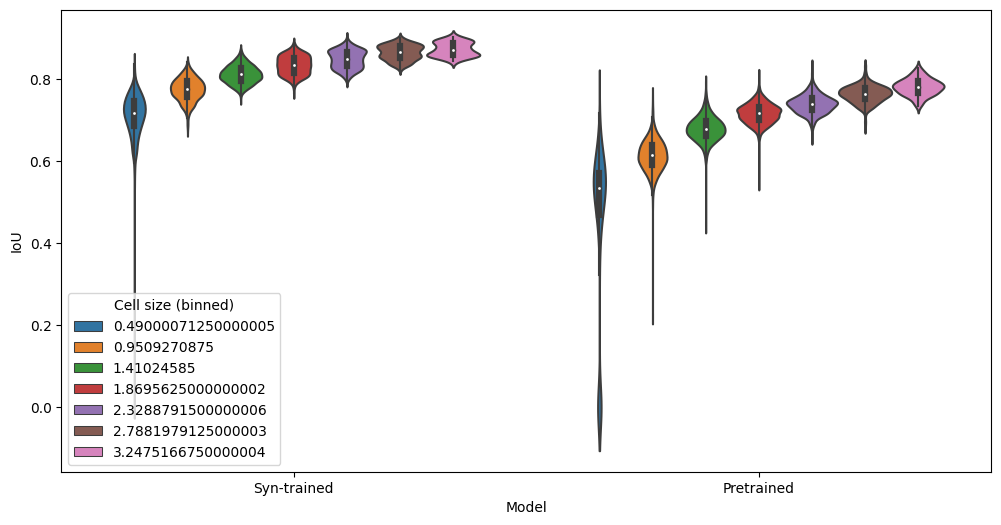

In [161]:
plt.figure(figsize=(12,6))
sns.violinplot(data = IoU_data, x = "Model", y = "IoU", hue="Cell size (binned)", split=False) # generalised IoU